# tf.data: Build TensorFlow input pipelines

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/guide/data"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/data.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/guide/data.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/guide/data.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

The `tf.data` API enables you to build complex input pipelines from simple,
reusable pieces. For example, the pipeline for an image model might aggregate
data from files in a distributed file system, apply random perturbations to each
image, and merge randomly selected images into a batch for training. The
pipeline for a text model might involve extracting symbols from raw text data,
converting them to embedding identifiers with a lookup table, and batching
together sequences of different lengths. The `tf.data` API makes it possible to
handle large amounts of data, read from different data formats, and perform
complex transformations.

The `tf.data` API introduces a `tf.data.Dataset` abstraction that represents a
sequence of elements, in which each element consists of one or more components.
For example, in an image pipeline, an element might be a single training
example, with a pair of tensor components representing the image and its label.

There are two distinct ways to create a dataset:

*   A data **source** constructs a `Dataset` from data stored in memory or in
    one or more files.

*   A data **transformation** constructs a dataset from one or more
    `tf.data.Dataset` objects.


In [1]:
import tensorflow as tf

In [2]:
tf.compat.v1.enable_eager_execution()

In [3]:
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

np.set_printoptions(precision=4)

## Basic mechanics
<a id="basic-mechanics"/>

To create an input pipeline, you must start with a data *source*. For example,
to construct a `Dataset` from data in memory, you can use
`tf.data.Dataset.from_tensors()` or `tf.data.Dataset.from_tensor_slices()`.
Alternatively, if your input data is stored in a file in the recommended
TFRecord format, you can use `tf.data.TFRecordDataset()`.

Once you have a `Dataset` object, you can *transform* it into a new `Dataset` by
chaining method calls on the `tf.data.Dataset` object. For example, you can
apply per-element transformations such as `Dataset.map`, and multi-element
transformations such as `Dataset.batch`. Refer to the documentation for
`tf.data.Dataset` for a complete list of transformations.

The `Dataset` object is a Python iterable. This makes it possible to consume its
elements using a for loop:

In [4]:
dataset = tf.data.Dataset.from_tensor_slices([8, 3, 0, 8, 2, 1])
dataset

2022-11-21 18:34:04.372803: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-11-21 18:34:04.397216: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla K40c major: 3 minor: 5 memoryClockRate(GHz): 0.745
pciBusID: 0000:81:00.0
2022-11-21 18:34:04.397477: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2022-11-21 18:34:04.398956: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-11-21 18:34:04.400141: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2022-11-21 18:34:04.400372: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2022-11-21 18:34:04.401783: I tensorflow/stream_executor/platform/defaul

<DatasetV1Adapter shapes: (), types: tf.int32>

In [5]:
# In TF1, we have to print the specification individually
dataset.element_spec

TensorSpec(shape=(), dtype=tf.int32, name=None)

In [6]:
for elem in dataset:
  print(elem.numpy())

8
3
0
8
2
1


Or by explicitly creating a Python iterator using `iter` and consuming its
elements using `next`:

In [7]:
it = iter(dataset)

print(next(it).numpy())

8


Alternatively, dataset elements can be consumed using the `reduce`
transformation, which reduces all elements to produce a single result. The
following example illustrates how to use the `reduce` transformation to compute
the sum of a dataset of integers.

In [8]:
# 0 for the initial_state
# https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/data/Dataset#reduce
print(dataset.reduce(0, lambda state, value: state + value).numpy())

22


<!-- TODO(jsimsa): Talk about `tf.function` support. -->

<a id="dataset_structure"></a>
### Dataset structure

A dataset produces a sequence of *elements*, where each element is
the same (nested) structure of *components*. Individual components
of the structure can be of any type representable by
`tf.TypeSpec`, including `tf.Tensor`, `tf.sparse.SparseTensor`,
`tf.RaggedTensor`, `tf.TensorArray`, or `tf.data.Dataset`.

The Python constructs that can be used to express the (nested)
structure of elements include `tuple`, `dict`, `NamedTuple`, and
`OrderedDict`. In particular, `list` is not a valid construct for
expressing the structure of dataset elements. This is because
early `tf.data` users felt strongly about `list` inputs (for example, when passed
to `tf.data.Dataset.from_tensors`) being automatically packed as
tensors and `list` outputs (for example, return values of user-defined
functions) being coerced into a `tuple`. As a consequence, if you
would like a `list` input to be treated as a structure, you need
to convert it into `tuple` and if you would like a `list` output
to be a single component, then you need to explicitly pack it
using `tf.stack`.

The `Dataset.element_spec` property allows you to inspect the type
of each element component. The property returns a *nested structure*
of `tf.TypeSpec` objects, matching the structure of the element,
which may be a single component, a tuple of components, or a nested
tuple of components. For example:

In [9]:
# The first dimension is for #batches
dataset1 = tf.data.Dataset.from_tensor_slices(tf.random.uniform([4, 10]))

dataset1.element_spec

TensorSpec(shape=(10,), dtype=tf.float32, name=None)

In [10]:
dataset2 = tf.data.Dataset.from_tensor_slices(
   (tf.random.uniform([4]),
    tf.random.uniform([4, 100], maxval=100, dtype=tf.int32)))

dataset2.element_spec

(TensorSpec(shape=(), dtype=tf.float32, name=None),
 TensorSpec(shape=(100,), dtype=tf.int32, name=None))

In [11]:
dataset3 = tf.data.Dataset.zip((dataset1, dataset2))

dataset3.element_spec

(TensorSpec(shape=(10,), dtype=tf.float32, name=None),
 (TensorSpec(shape=(), dtype=tf.float32, name=None),
  TensorSpec(shape=(100,), dtype=tf.int32, name=None)))

In [12]:
# Dataset containing a sparse tensor.
# COO format, indices records the location, dense_shape is the total shape
dataset4 = tf.data.Dataset.from_tensors(tf.SparseTensor(indices=[[0, 0], [1, 2]], values=[1, 2], dense_shape=[3, 4]))

dataset4.element_spec

SparseTensorSpec(TensorShape([Dimension(3), Dimension(4)]), tf.int32)

In [13]:
# Use value_type to see the type of value represented by the element spec
dataset4.element_spec.value_type

tensorflow.python.framework.sparse_tensor.SparseTensor

The `Dataset` transformations support datasets of any structure. When using the
`Dataset.map`, and `Dataset.filter` transformations,
which apply a function to each element, the element structure determines the
arguments of the function:

In [14]:
dataset1 = tf.data.Dataset.from_tensor_slices(
    tf.random.uniform([4, 10], minval=1, maxval=10, dtype=tf.int32))

dataset1

<DatasetV1Adapter shapes: (10,), types: tf.int32>

In [15]:
dataset1.element_spec

TensorSpec(shape=(10,), dtype=tf.int32, name=None)

In [16]:
for z in dataset1:
  print(z.numpy())

[9 5 3 7 7 3 3 7 1 4]
[2 8 6 7 9 1 6 9 6 4]
[3 1 5 7 4 9 9 2 7 4]
[7 5 3 3 6 9 6 1 9 4]


In [17]:
dataset2 = tf.data.Dataset.from_tensor_slices(
   (tf.random.uniform([4]),
    tf.random.uniform([4, 100], maxval=100, dtype=tf.int32)))

dataset2

<DatasetV1Adapter shapes: ((), (100,)), types: (tf.float32, tf.int32)>

In [18]:
# in TF1, the element specification is not shown when we display the dataset object
dataset2.element_spec

(TensorSpec(shape=(), dtype=tf.float32, name=None),
 TensorSpec(shape=(100,), dtype=tf.int32, name=None))

In [19]:
dataset3 = tf.data.Dataset.zip((dataset1, dataset2))

dataset3

<DatasetV1Adapter shapes: ((10,), ((), (100,))), types: (tf.int32, (tf.float32, tf.int32))>

In [20]:
dataset3.element_spec

(TensorSpec(shape=(10,), dtype=tf.int32, name=None),
 (TensorSpec(shape=(), dtype=tf.float32, name=None),
  TensorSpec(shape=(100,), dtype=tf.int32, name=None)))

In [21]:
for a, (b,c) in dataset3:
  print('shapes: {a.shape}, {b.shape}, {c.shape}'.format(a=a, b=b, c=c))

shapes: (10,), (), (100,)
shapes: (10,), (), (100,)
shapes: (10,), (), (100,)
shapes: (10,), (), (100,)


## Reading input data


### Consuming NumPy arrays

Refer to the [Loading NumPy arrays](../tutorials/load_data/numpy.ipynb) tutorial for more examples.

If all of your input data fits in memory, the simplest way to create a `Dataset`
from them is to convert them to `tf.Tensor` objects and use
`Dataset.from_tensor_slices`.

In [22]:
train, test = tf.keras.datasets.fashion_mnist.load_data()

In [23]:
images, labels = train
images = images/255

dataset = tf.data.Dataset.from_tensor_slices((images, labels))
dataset

<DatasetV1Adapter shapes: ((28, 28), ()), types: (tf.float64, tf.uint8)>

In [24]:
dataset.element_spec

(TensorSpec(shape=(28, 28), dtype=tf.float64, name=None),
 TensorSpec(shape=(), dtype=tf.uint8, name=None))

Note: The above code snippet will embed the `features` and `labels` arrays
in your TensorFlow graph as `tf.constant()` operations. This works well for a
small dataset, but wastes memory---because the contents of the array will be
copied multiple times---and can run into the 2GB limit for the `tf.GraphDef`
protocol buffer.

### Consuming Python generators

Another common data source that can easily be ingested as a `tf.data.Dataset` is the python generator.

Caution: While this is a convenient approach it has limited portability and scalability. It must run in the same python process that created the generator, and is still subject to the Python [GIL](https://en.wikipedia.org/wiki/Global_interpreter_lock).

In [25]:
def count(stop):
  i = 0
  while i<stop:
    yield i
    i += 1

In [26]:
for n in count(5):
  print(n)

0
1
2
3
4


The `Dataset.from_generator` constructor converts the python generator to a fully functional `tf.data.Dataset`.

The constructor takes a callable as input, not an iterator. This allows it to restart the generator when it reaches the end. It takes an optional `args` argument, which is passed as the callable's arguments.

The `output_types` argument is required because `tf.data` builds a `tf.Graph` internally, and graph edges require a `tf.dtype`.

In [27]:
ds_counter = tf.data.Dataset.from_generator(count, args=[25], output_types=tf.int32, output_shapes = (), )

In [28]:
# repeat without arguments makes it infinity
# batch combines consecutive elements into batches 
# the take(#) method would return at most #elements from the dataset
# note, every methods would return a new dataset based on its operation
for count_batch in ds_counter.repeat().batch(10).take(11):
  print(count_batch.numpy())

[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24  0  1  2  3  4]
[ 5  6  7  8  9 10 11 12 13 14]
[15 16 17 18 19 20 21 22 23 24]
[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24  0  1  2  3  4]
[ 5  6  7  8  9 10 11 12 13 14]
[15 16 17 18 19 20 21 22 23 24]
[0 1 2 3 4 5 6 7 8 9]


The `output_shapes` argument is not *required* but is highly recommended as many TensorFlow operations do not support tensors with an unknown rank. If the length of a particular axis is unknown or variable, set it as `None` in the `output_shapes`.

It's also important to note that the `output_shapes` and `output_types` follow the same nesting rules as other dataset methods.

Here is an example generator that demonstrates both aspects: it returns tuples of arrays, where the second array is a vector with **unknown** length.

In [29]:
def gen_series():
  i = 0
  while True:
    size = np.random.randint(0, 10)
    yield i, np.random.normal(size=(size,))
    i += 1

In [30]:
for i, series in gen_series():
  print(i, ":", str(series))
  if i > 5:
    break

0 : [-1.631  -0.0485  0.963  -0.6152  1.5837 -0.2283  1.3243  0.4634  0.5242]
1 : [ 0.9978 -1.9544 -0.5433  0.5619  0.8694  0.0352 -0.4365 -2.1088 -0.3581]
2 : [-0.7991]
3 : [1.9339]
4 : [-1.2122 -1.8408  0.2378 -0.171   1.191  -0.5953  0.592  -0.7713 -0.3356]
5 : [-0.2731  1.5061 -1.5291  0.1476]
6 : [-1.0994  0.2426  0.6826  0.7351 -0.6473 -0.2822 -0.7393 -0.8896 -0.6772]


The first output is an `int32` the second is a `float32`.

The first item is a scalar, shape `()`, and the second is a vector of unknown length, shape `(None,)` 

In [31]:
ds_series = tf.data.Dataset.from_generator(
    gen_series, 
    output_types=(tf.int32, tf.float32), 
    output_shapes=((), (None,)))

ds_series

<DatasetV1Adapter shapes: ((), (?,)), types: (tf.int32, tf.float32)>

In [32]:
# It seems that ? is None in TF1.x
ds_series.element_spec

(TensorSpec(shape=(), dtype=tf.int32, name=None),
 TensorSpec(shape=(?,), dtype=tf.float32, name=None))

Now it can be used like a regular `tf.data.Dataset`. Note that when batching a dataset with a variable shape, you need to use `Dataset.padded_batch`.

In [33]:
# In TF1.x, we have to specify the padded_shapes
ds_series_batch = ds_series.shuffle(20).padded_batch(10, padded_shapes=([], [None]))

ids, sequence_batch = next(iter(ds_series_batch))
print(ids.numpy())
print()
print(sequence_batch.numpy())

[ 2 15 19  8 17  6 20 13  3 12]

[[-0.8784 -1.6013  0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.2632 -0.2919 -0.7798 -0.8509 -0.4747  0.1248  0.3899  0.    ]
 [ 0.1095 -0.9177 -0.538   0.      0.      0.      0.      0.    ]
 [-1.0629  0.3491  1.3981  0.      0.      0.      0.      0.    ]
 [-0.955   0.      0.      0.      0.      0.      0.      0.    ]
 [-0.0214  0.5775  0.      0.      0.      0.      0.      0.    ]
 [-1.1235  0.14    0.7253  1.1314  2.2459  1.3201 -0.1693  0.1281]]


For a more realistic example, try wrapping `preprocessing.image.ImageDataGenerator` as a `tf.data.Dataset`.

First download the data:

In [34]:
flowers = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

Create the `image.ImageDataGenerator`

In [35]:
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=20)

In [36]:
images, labels = next(img_gen.flow_from_directory(flowers))

Found 3670 images belonging to 5 classes.


In [37]:
print(images.dtype, images.shape)
print(labels.dtype, labels.shape)

float32 (32, 256, 256, 3)
float32 (32, 5)


In [38]:
ds = tf.data.Dataset.from_generator(
    lambda: img_gen.flow_from_directory(flowers), 
    output_types=(tf.float32, tf.float32), 
    output_shapes=([32, 256, 256, 3], [32, 5])
)

ds.element_spec

(TensorSpec(shape=(32, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(32, 5), dtype=tf.float32, name=None))

In [39]:
for images, labels in ds.take(1):
  print('images.shape: ', images.shape)
  print('labels.shape: ', labels.shape)

Found 3670 images belonging to 5 classes.
images.shape:  (32, 256, 256, 3)
labels.shape:  (32, 5)


---

### Consuming CSV data

Refer to the [Loading CSV Files](../tutorials/load_data/csv.ipynb) and [Loading Pandas DataFrames](../tutorials/load_data/pandas_dataframe.ipynb) tutorials for more examples.

The CSV file format is a popular format for storing tabular data in plain text.

For example:

In [40]:
titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")

In [41]:
df = pd.read_csv(titanic_file)
df.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


If your data fits in memory the same `Dataset.from_tensor_slices` method works on dictionaries, allowing this data to be easily imported:

In [42]:
titanic_slices = tf.data.Dataset.from_tensor_slices(dict(df))

for feature_batch in titanic_slices.take(1):
  for key, value in feature_batch.items():
    print("  {!r:20s}: {}".format(key, value))

  'survived'          : 0
  'sex'               : b'male'
  'age'               : 22.0
  'n_siblings_spouses': 1
  'parch'             : 0
  'fare'              : 7.25
  'class'             : b'Third'
  'deck'              : b'unknown'
  'embark_town'       : b'Southampton'
  'alone'             : b'n'


A more scalable approach is to load from disk as necessary.

The `tf.data` module provides methods to extract records from one or more CSV files that comply with [RFC 4180](https://tools.ietf.org/html/rfc4180).

The `tf.data.experimental.make_csv_dataset` function is the high-level interface for reading sets of CSV files. It supports column type inference and many other features, like batching and shuffling, to make usage simple.

In [43]:
titanic_batches = tf.data.experimental.make_csv_dataset(
    titanic_file, batch_size=4,
    label_name="survived")

Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.
Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


In [44]:
for feature_batch, label_batch in titanic_batches.take(1):
  print("'survived': {}".format(label_batch))
  print("features:")
  for key, value in feature_batch.items():
    print("  {!r:20s}: {}".format(key, value))

'survived': [1 0 1 0]
features:
  'sex'               : [b'female' b'male' b'male' b'male']
  'age'               : [28.  34.5 27.  33. ]
  'n_siblings_spouses': [1 0 0 1]
  'parch'             : [0 0 0 1]
  'fare'              : [51.8625  6.4375 30.5    20.525 ]
  'class'             : [b'First' b'Third' b'First' b'Third']
  'deck'              : [b'D' b'unknown' b'unknown' b'unknown']
  'embark_town'       : [b'Southampton' b'Cherbourg' b'Southampton' b'Southampton']
  'alone'             : [b'n' b'y' b'y' b'n']


You can use the `select_columns` argument if you only need a subset of columns.

In [45]:
titanic_batches = tf.data.experimental.make_csv_dataset(
    titanic_file, batch_size=4,
    label_name="survived", select_columns=['class', 'fare', 'survived'])

In [46]:
for feature_batch, label_batch in titanic_batches.take(1):
  print("'survived': {}".format(label_batch))
  for key, value in feature_batch.items():
    print("  {!r:20s}: {}".format(key, value))

'survived': [0 0 1 0]
  'fare'              : [27.9     9.8458 10.5    26.    ]
  'class'             : [b'Third' b'Third' b'Second' b'First']


There is also a lower-level `experimental.CsvDataset` class which provides finer grained control. It does not support column type inference. Instead you must specify the type of each column.

In [47]:
titanic_types  = [tf.int32, tf.string, tf.float32, tf.int32, tf.int32, tf.float32, tf.string, tf.string, tf.string, tf.string]
dataset = tf.data.experimental.CsvDataset(titanic_file, titanic_types , header=True)

for line in dataset.take(10):
  print([item.numpy() for item in line])

[0, b'male', 22.0, 1, 0, 7.25, b'Third', b'unknown', b'Southampton', b'n']
[1, b'female', 38.0, 1, 0, 71.2833, b'First', b'C', b'Cherbourg', b'n']
[1, b'female', 26.0, 0, 0, 7.925, b'Third', b'unknown', b'Southampton', b'y']
[1, b'female', 35.0, 1, 0, 53.1, b'First', b'C', b'Southampton', b'n']
[0, b'male', 28.0, 0, 0, 8.4583, b'Third', b'unknown', b'Queenstown', b'y']
[0, b'male', 2.0, 3, 1, 21.075, b'Third', b'unknown', b'Southampton', b'n']
[1, b'female', 27.0, 0, 2, 11.1333, b'Third', b'unknown', b'Southampton', b'n']
[1, b'female', 14.0, 1, 0, 30.0708, b'Second', b'unknown', b'Cherbourg', b'n']
[1, b'female', 4.0, 1, 1, 16.7, b'Third', b'G', b'Southampton', b'n']
[0, b'male', 20.0, 0, 0, 8.05, b'Third', b'unknown', b'Southampton', b'y']


If some columns are empty, this low-level interface allows you to provide default values instead of column types.

In [48]:
%%writefile missing.csv
1,2,3,4
,2,3,4
1,,3,4
1,2,,4
1,2,3,
,,,

Overwriting missing.csv


In [49]:
# Creates a dataset that reads all of the records from two CSV files, each with
# four float columns which may have missing values.

record_defaults = [999,999,999,999]
dataset = tf.data.experimental.CsvDataset("missing.csv", record_defaults)
dataset = dataset.map(lambda *items: tf.stack(items))
dataset

<DatasetV1Adapter shapes: (4,), types: tf.int32>

In [50]:
for line in dataset:
  print(line.numpy())

[1 2 3 4]
[999   2   3   4]
[  1 999   3   4]
[  1   2 999   4]
[  1   2   3 999]
[999 999 999 999]


By default, a `CsvDataset` yields *every* column of *every* line of the file,
which may not be desirable, for example if the file starts with a header line
that should be ignored, or if some columns are not required in the input.
These lines and fields can be removed with the `header` and `select_cols`
arguments respectively.

In [51]:
# Creates a dataset that reads all of the records from two CSV files with
# headers, extracting float data from columns 2 and 4.
record_defaults = [999, 999] # Only provide defaults for the selected columns
dataset = tf.data.experimental.CsvDataset("missing.csv", record_defaults, select_cols=[1, 3])
dataset = dataset.map(lambda *items: tf.stack(items))
dataset

<DatasetV1Adapter shapes: (2,), types: tf.int32>

In [52]:
for line in dataset:
  print(line.numpy())

[2 4]
[2 4]
[999   4]
[2 4]
[  2 999]
[999 999]


<!--
TODO(mrry): Add this section.

### Handling text data with unusual sizes
-->

## Batching dataset elements


### Simple batching

The simplest form of batching stacks `n` consecutive elements of a dataset into
a single element. The `Dataset.batch()` transformation does exactly this, with
the same constraints as the `tf.stack()` operator applied to each component
of the elements: I.e. all elements must have a tensor of the exact same shape.

In [53]:
inc_dataset = tf.data.Dataset.range(100)
dec_dataset = tf.data.Dataset.range(0, -100, -1)
dataset = tf.data.Dataset.zip((inc_dataset, dec_dataset))
batched_dataset = dataset.batch(4)

for batch in batched_dataset.take(4):
  print([arr.numpy() for arr in batch])

[array([0, 1, 2, 3]), array([ 0, -1, -2, -3])]
[array([4, 5, 6, 7]), array([-4, -5, -6, -7])]
[array([ 8,  9, 10, 11]), array([ -8,  -9, -10, -11])]
[array([12, 13, 14, 15]), array([-12, -13, -14, -15])]


While `tf.data` tries to propagate shape information, the default settings of `Dataset.batch` result in an **unknown batch size** because the last batch may not be full. Note the `None`s in the shape:

In [54]:
batched_dataset

<DatasetV1Adapter shapes: ((?,), (?,)), types: (tf.int64, tf.int64)>

In [55]:
batched_dataset.element_spec

(TensorSpec(shape=(?,), dtype=tf.int64, name=None),
 TensorSpec(shape=(?,), dtype=tf.int64, name=None))

Use the `drop_remainder` argument to ignore that last batch, and get full shape propagation:

In [56]:
batched_dataset = dataset.batch(7, drop_remainder=True)
batched_dataset

<DatasetV1Adapter shapes: ((7,), (7,)), types: (tf.int64, tf.int64)>

### Batching tensors with padding

The above recipe works for tensors that all have the same size. However, many
models (including sequence models) work with input data that can have varying size
(for example, sequences of different lengths). To handle this case, the
`Dataset.padded_batch` transformation enables you to batch tensors of
different shapes by specifying one or more dimensions in which they may be
padded.

In [57]:
dataset = tf.data.Dataset.range(100)
dataset = dataset.map(lambda x: tf.fill([tf.cast(x, tf.int32)], x))
dataset = dataset.padded_batch(4, padded_shapes=(None,))

for batch in dataset.take(2):
  print(batch.numpy())
  print()


[[0 0 0]
 [1 0 0]
 [2 2 0]
 [3 3 3]]

[[4 4 4 4 0 0 0]
 [5 5 5 5 5 0 0]
 [6 6 6 6 6 6 0]
 [7 7 7 7 7 7 7]]



The `Dataset.padded_batch` transformation allows you to set different padding
for each dimension of each component, and it may be variable-length (signified
by `None` in the example above) or constant-length. It is also possible to
override the padding value, which defaults to 0.

<!--
TODO(mrry): Add this section.

### Dense ragged -> tf.SparseTensor
-->


## Training workflows


### Processing multiple epochs

The `tf.data` API offers two main ways to process multiple epochs of the same
data.

The simplest way to iterate over a dataset in multiple epochs is to use the
`Dataset.repeat()` transformation. First, create a dataset of titanic data:

In [58]:
titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic_lines = tf.data.TextLineDataset(titanic_file)

In [59]:
def plot_batch_sizes(ds):
  # https://stackoverflow.com/a/43777611/7653982
  # In TF1.x, batch.shape[0] is of type Dimension, we need to extract the values
  batch_sizes = [batch.shape[0].value for batch in ds]
  plt.bar(range(len(batch_sizes)), batch_sizes)
  plt.xlabel('Batch number')
  plt.ylabel('Batch size')

Applying the `Dataset.repeat()` transformation with no arguments will repeat
the input indefinitely.

The `Dataset.repeat` transformation concatenates its
arguments without signaling the end of one epoch and the beginning of the next
epoch. Because of this a `Dataset.batch` applied after `Dataset.repeat` will yield batches that **straddle** epoch boundaries:

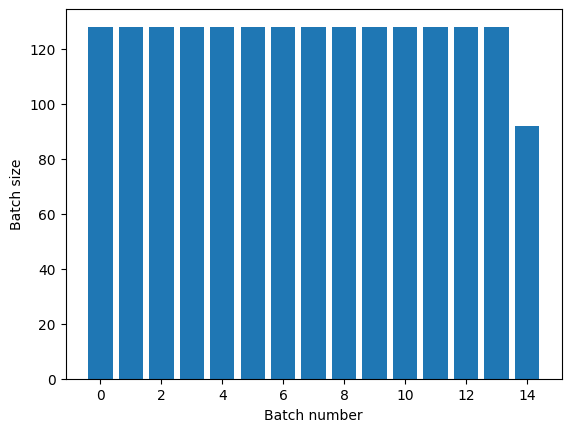

In [60]:
titanic_batches = titanic_lines.repeat(3).batch(128)
plot_batch_sizes(titanic_batches)

If you need clear epoch separation, put `Dataset.batch` before the repeat:

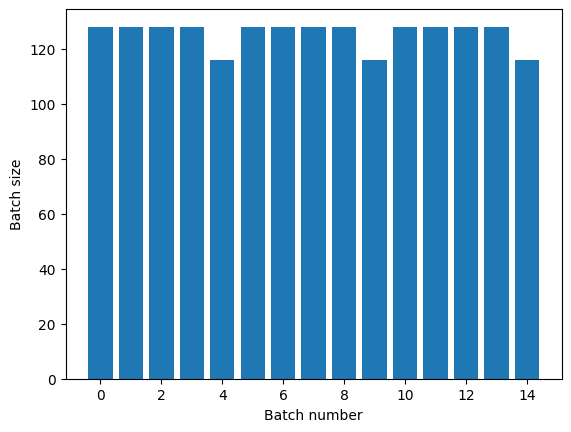

In [61]:
titanic_batches = titanic_lines.batch(128).repeat(3)

plot_batch_sizes(titanic_batches)

**NB: To have clear epoch boundaries in batches, put `batch` before `repeat`.**

If you would like to perform a custom computation (for example, to collect statistics) at the end of each epoch then it's simplest to restart the dataset iteration on each epoch:

In [62]:
epochs = 3
dataset = titanic_lines.batch(128)

for epoch in range(epochs):
  for batch in dataset:
    print(batch.shape)
  print("End of epoch: ", epoch)

(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  0
(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  1
(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  2


### Randomly shuffling input data

The `Dataset.shuffle()` transformation maintains a fixed-size
buffer and chooses the next element uniformly at random from that buffer.

Note: While large buffer_sizes shuffle more thoroughly, they can take a lot of memory, and significant time to fill. Consider using `Dataset.interleave` across files if this becomes a problem.

**Note 2: If the buffer_size is small than the dataset size, it virtually makes the datasets smaller for the following operations (e.g., the batch operation).**

Add an index to the dataset so you can see the effect:

In [63]:
lines = tf.data.TextLineDataset(titanic_file)
counter = tf.data.experimental.Counter()

dataset = tf.data.Dataset.zip((counter, lines))
dataset = dataset.shuffle(buffer_size=100)
dataset = dataset.batch(20)
dataset

<DatasetV1Adapter shapes: ((?,), (?,)), types: (tf.int64, tf.string)>

In [64]:
dataset.element_spec

(TensorSpec(shape=(?,), dtype=tf.int64, name=None),
 TensorSpec(shape=(?,), dtype=tf.string, name=None))

In [65]:
# https://stackoverflow.com/a/56368864/7653982
len(list(lines))

628

Since the `buffer_size` is 100, and the batch size is 20, the first batch contains no elements with an index over 120.

* The buffer remains 100, the batch would take elements out of it one by one. 
    * For the first element, it sees the first 100 elements.
    * After the first one being taken, the taken element got replaced (100). 
    * The second element is chosen again from the 100 elements buffer, where the missing one is replaced by 100. 
    * Due to this replacement mechanism, we get the index of 120 at the end. 

In [66]:
n,line_batch = next(iter(dataset))
print(n.numpy())

[ 21  28  93 101  62  25  64  15   9  81  35  69  22  30  49  12  33  73
 100  91]


As with `Dataset.batch` the order relative to `Dataset.repeat` matters.

`Dataset.shuffle` doesn't signal the end of an epoch until the shuffle buffer is empty. So a shuffle placed before a repeat will show every element of one epoch before moving to the next:

In [67]:
dataset = tf.data.Dataset.zip((counter, lines))
shuffled = dataset.shuffle(buffer_size=100).batch(10).repeat(2)

print("Here are the item ID's near the epoch boundary:\n")
for n, line_batch in shuffled.skip(60).take(5):
  print(n.numpy())

Here are the item ID's near the epoch boundary:

[553 577 605 545 608 581 433 470 575 579]
[572 623 524 609 593 551 586 596 501 529]
[618 591 546 449 600 603 580 366]
[85 22 88 32  9 90 82 25 21  0]
[ 43  36  66  51 104  39  59  16  73  42]


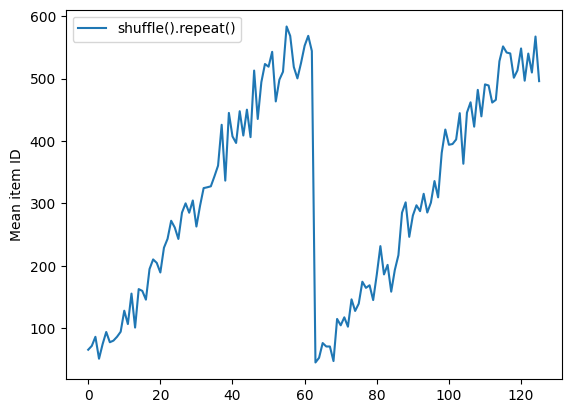

In [68]:
shuffle_repeat = [n.numpy().mean() for n, line_batch in shuffled]
plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.ylabel("Mean item ID")
plt.legend()

But a repeat before a shuffle mixes the epoch boundaries together:

In [69]:
dataset = tf.data.Dataset.zip((counter, lines))
shuffled = dataset.repeat(2).shuffle(buffer_size=100).batch(10)

print("Here are the item ID's near the epoch boundary:\n")
for n, line_batch in shuffled.skip(55).take(15):
  print(n.numpy())

Here are the item ID's near the epoch boundary:

[551 521 577  16 610   8 507 476 397 482]
[ 24 609  14  23 625 498 510 594 547  17]
[548 492 603 552  28   5 512 616  41 614]
[ 27 466 575 585 402 612   0  51 546  32]
[572 504  35 530  59 446  43 607  65  15]
[375  10  69 526  31  21  57 485  20   6]
[441 516   9  70  52 618  39  37  26  53]
[590  87  62 301 553  74  83  19  68 582]
[308  30  34 236 100  91  88  66 541 442]
[200 542 615 622   2 109  77 520 113  67]
[571  94 495 105  38 532  89  71 605  98]
[ 99 613 620  25 574  49 544  60  81  11]
[120  50 119 142 555 102 133  82  42  33]
[567 592 536 143 137 118 134 148  97 131]
[ 90  46 126 128 104 576 139 127  36  40]


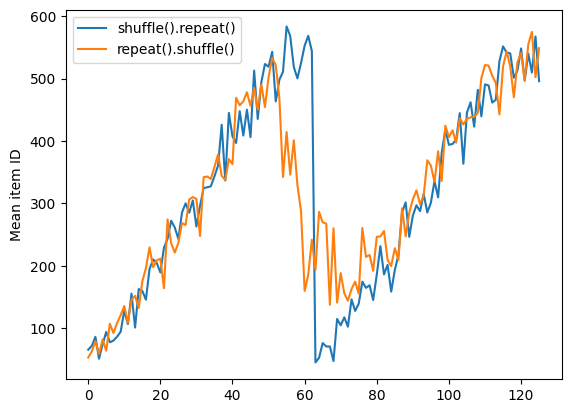

In [70]:
repeat_shuffle = [n.numpy().mean() for n, line_batch in shuffled]

plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.plot(repeat_shuffle, label="repeat().shuffle()")
plt.ylabel("Mean item ID")
plt.legend()

**NB: To avoid mixing values across epoch boundaries, use `shuffle()` before `repeat()`.**

## Preprocessing data

The `Dataset.map(f)` transformation produces a new dataset by applying a given
function `f` to each element of the input dataset. It is based on the
[`map()`](https://en.wikipedia.org/wiki/Map_\(higher-order_function\)) function
that is commonly applied to lists (and other structures) in functional
programming languages. The function `f` takes the `tf.Tensor` objects that
represent a single element in the input, and returns the `tf.Tensor` objects
that will represent a single element in the new dataset. Its implementation uses
standard TensorFlow operations to transform one element into another.

This section covers common examples of how to use `Dataset.map()`.


### Decoding image data and resizing it

<!-- TODO(markdaoust): link to image augmentation when it exists -->
When training a neural network on real-world image data, it is often necessary
to convert images of different sizes to a common size, so that they may be
batched into a fixed size.

Rebuild the flower filenames dataset:

In [71]:
flowers_root = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)
flowers_root = pathlib.Path(flowers_root)

In [72]:
list_ds = tf.data.Dataset.list_files(str(flowers_root/'*/*'))

Write a function that manipulates the dataset elements.

In [73]:
# Reads an image from a file, decodes it into a dense tensor, and resizes it
# to a fixed shape.
def parse_image(filename):
  parts = tf.strings.split(filename, os.sep, result_type='RaggedTensor')
  label = parts[-2]

  image = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [128, 128])
  return image, label

Test that it works.

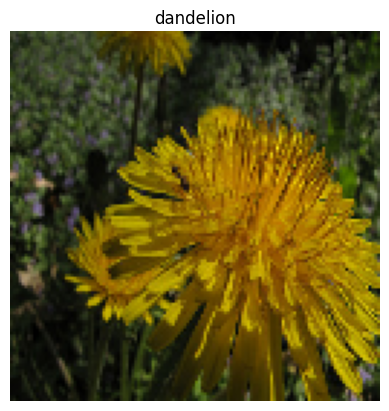

In [74]:
file_path = next(iter(list_ds))
image, label = parse_image(file_path)

def show(image, label):
  plt.figure()
  plt.imshow(image)
  plt.title(label.numpy().decode('utf-8'))
  plt.axis('off')

show(image, label)

Map it over the dataset.

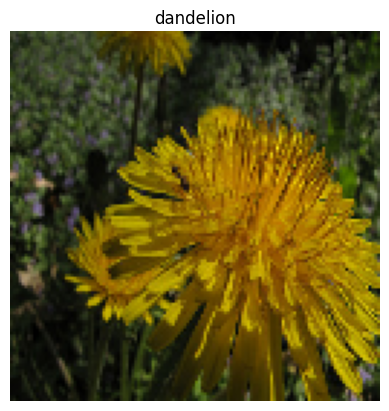

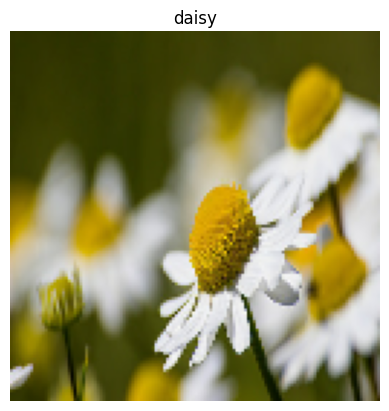

In [75]:
images_ds = list_ds.map(parse_image)

for image, label in images_ds.take(2):
  show(image, label)

### Applying arbitrary Python logic

For performance reasons, use TensorFlow operations for
preprocessing your data whenever possible. However, it is sometimes useful to
call external Python libraries when parsing your input data. You can use the `tf.py_function` operation in a `Dataset.map` transformation.

For example, if you want to apply a random rotation, the `tf.image` module only has `tf.image.rot90`, which is not very useful for image augmentation.

Note: `tensorflow_addons` has a TensorFlow compatible `rotate` in `tensorflow_addons.image.rotate`.

To demonstrate `tf.py_function`, try using the `scipy.ndimage.rotate` function instead:

In [76]:
import scipy.ndimage as ndimage

def random_rotate_image(image):
  image = ndimage.rotate(image, np.random.uniform(-30, 30), reshape=False)
  return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


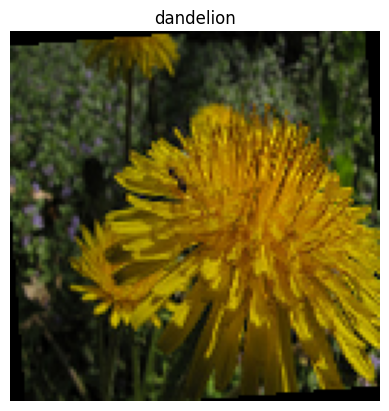

In [77]:
image, label = next(iter(images_ds))
image = random_rotate_image(image)
show(image, label)

To use this function with `Dataset.map` the same caveats apply as with `Dataset.from_generator`, you need to describe the return shapes and types when you apply the function:

In [78]:
def tf_random_rotate_image(image, label):
  im_shape = image.shape
  [image,] = tf.py_function(random_rotate_image, [image], [tf.float32])
  image.set_shape(im_shape)
  return image, label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


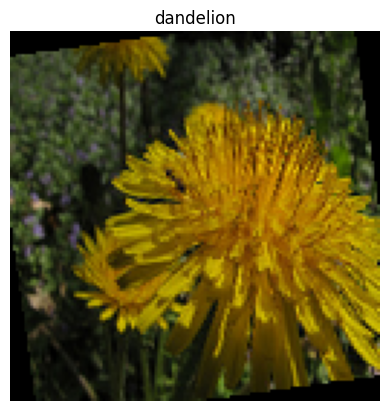

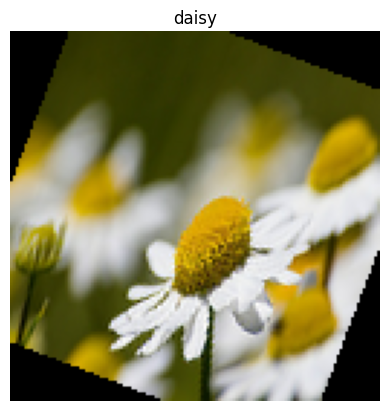

In [79]:
rot_ds = images_ds.map(tf_random_rotate_image)

for image, label in rot_ds.take(2):
  show(image, label)

## Using `tf.data` with `tf.keras`

The `tf.keras` API simplifies many aspects of creating and executing machine
learning models. Its `Model.fit` and `Model.evaluate` and `Model.predict` APIs support datasets as inputs. Here is a quick dataset and model setup:

In [80]:
train, test = tf.keras.datasets.fashion_mnist.load_data()

images, labels = train
images = images/255.0
labels = labels.astype(np.int32)

In [81]:
fmnist_train_ds = tf.data.Dataset.from_tensor_slices((images, labels))
fmnist_train_ds = fmnist_train_ds.shuffle(5000).batch(32)

model = tf.keras.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

 Passing a dataset of `(feature, label)` pairs is all that's needed for `Model.fit` and `Model.evaluate`:

In [82]:
model.fit(fmnist_train_ds, epochs=2)

Epoch 1/2
      4/Unknown - 1s 219ms/step - loss: 2.5507 - acc: 0.0781

2022-11-21 18:34:14.205395: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0


1875/1875 [==============================] - 10s 5ms/step - loss: 0.6019 - acc: 0.7973
Epoch 2/2


2022-11-21 18:34:23.722601: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[loss/output_1_loss/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits/_18]]
2022-11-21 18:34:23.722757: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


1875/1875 [==============================] - 7s 4ms/step - loss: 0.4635 - acc: 0.8408


2022-11-21 18:34:30.591904: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[loss/output_1_loss/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits/_18]]
2022-11-21 18:34:30.592032: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


If you pass an infinite dataset, for example by calling `Dataset.repeat`, you just need to also pass the `steps_per_epoch` argument:

In [83]:
model.fit(fmnist_train_ds.repeat(), epochs=2, steps_per_epoch=20)

Train for 20 steps
Epoch 1/2
20/20 [==============================] - 0s 18ms/step - loss: 0.4204 - acc: 0.8500
Epoch 2/2
20/20 [==============================] - 0s 3ms/step - loss: 0.5015 - acc: 0.8219


For evaluation you can pass the number of evaluation steps:

In [84]:
loss, accuracy = model.evaluate(fmnist_train_ds)
print("Loss :", loss)
print("Accuracy :", accuracy)

1875/1875 [==============================] - 5s 3ms/step - loss: 0.4430 - acc: 0.8466
Loss : 0.44302847580747123
Accuracy : 0.8466333


For long datasets, set the number of steps to evaluate:

In [85]:
loss, accuracy = model.evaluate(fmnist_train_ds.repeat(), steps=10)
print("Loss :", loss)
print("Accuracy :", accuracy)

10/10 [==============================] - 0s 7ms/step - loss: 0.4389 - acc: 0.8719
Loss : 0.4388889127605438
Accuracy : 0.871875


The labels are not required when calling `Model.predict`.

In [86]:
predict_ds = tf.data.Dataset.from_tensor_slices(images).batch(32)
result = model.predict(predict_ds, steps = 10)
print(result.shape)

(320, 10)


But the labels are ignored if you do pass a dataset containing them:

In [87]:
result = model.predict(fmnist_train_ds, steps = 10)
print(result.shape)

(320, 10)
